# Recommendation Systems

This notebook aims to present how to create the algorithm for recommending beers.

There are two types of recommendation systems:

1. Content-based filtering (mapping items and users into a feature space)
  1. Computing distance between items and users using dot products
  1. Predicting ratings (or likes/dislikes) given the features
  
1. Collaborative filtering
  1. Item-based: compute similarity between items, recommend items most similar to user's items
  2. Model-based: use technqiues to find latent variables (i.e., deeper structure) in the ratings data, for example matrix decomposition techniques.  Ratings are constructed by taking dot products of user & item vectors in the latent feature space.
  

### Data Exploration

Please download the **[beer reviews](https://s3.amazonaws.com/demo-datasets/beer_reviews.tar.gz) dataset.** 

#### Loading code and data 

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from patsy import dmatrix
import seaborn as sb
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("beer_reviews/beer_reviews.csv")

In [3]:
print "We have {} reviews for {} beers from {} breweries, by {} drinkers.".format(len(data), 
                                                                                 data.beer_beerid.nunique(), 
                                                                                 data.brewery_id.nunique(), 
                                                                                 data.review_profilename.nunique())

We have 1586614 reviews for 66055 beers from 5840 breweries, by 33387 drinkers.


We could definitely truncate the data to speed up calculations. 

In [4]:
N = 150000
data = data.iloc[:N]
print "We have {} reviews for {} beers from {} breweries, by {} drinkers.".format(len(data), 
                                                                                  data.beer_beerid.nunique(), 
                                                                                  data.brewery_id.nunique(), 
                                                                                  data.review_profilename.nunique())

We have 150000 reviews for 6420 beers from 589 breweries, by 13964 drinkers.


In [5]:
data.head(3)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215


#### Data exploration

Let's see per features how many categories we have.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 13 columns):
brewery_id            150000 non-null int64
brewery_name          150000 non-null object
review_time           150000 non-null int64
review_overall        150000 non-null float64
review_aroma          150000 non-null float64
review_appearance     150000 non-null float64
review_profilename    149973 non-null object
beer_style            150000 non-null object
review_palate         150000 non-null float64
review_taste          150000 non-null float64
beer_name             150000 non-null object
beer_abv              144889 non-null float64
beer_beerid           150000 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 14.9+ MB


==> missing 'review_profilename' and 'beer_abv'

In [7]:
for col in data:
    print "{:20s}: {:7} uniques".format(col, data[col].nunique())

brewery_id          :     589 uniques
brewery_name        :     589 uniques
review_time         :  149904 uniques
review_overall      :      10 uniques
review_aroma        :       9 uniques
review_appearance   :      10 uniques
review_profilename  :   13964 uniques
beer_style          :     102 uniques
review_palate       :       9 uniques
review_taste        :       9 uniques
beer_name           :    6101 uniques
beer_abv            :     177 uniques
beer_beerid         :    6420 uniques


Note that
- our items are in `beer_beerid` (note that the names in `beer_name` are not unique),
- our users are `review_profilename`,
- we will use `review_overall` as rating, although we have many more (`aroma`, `appearance`, `palate`, and `taste`)
- we have only a few features: `brewery_id` (or `brewery_name`), `beer_abv` (% alcohol), and `beer_style`. We'll ignore `review_time`, although you might be able to spot differences in popularity over time.


USERS

--> `review_profilename` (there are 13964 users or reviewers)

ITEMS

--> `beer_beerid`  (there are 6420 beers reviewed)


RATINGS

--> `review_overall` (10 uniques -- rating goes from 1 to 5 (ratings are 0, 1, 1.5, 2, 2.5, etc.)

   Other ratings can be used: `review_aroma`, `review_appearance`, `review_palate`, `review_taste`
   
FEATURES

--> `brewery_id` (or `brewery_name`), `beer_abv` (% alcohol), and `beer_style`


Since the beer names are not unique, we will use the beer IDs. Let's make a lookup table from `beer_beerid` to `beername`, so we can easily track the beer's name as well.

In [8]:
beer_names = data.groupby('beer_beerid').beer_name.first()  # only one name per ID

In [9]:
beer_names.head()

beer_beerid
3             Cactus Queen IPA
4     Wildcatter's Crude Stout
80         Organic Münster Alt
81             Organic Ur Pils
82         Organic Hefe-Weizen
Name: beer_name, dtype: object

Let's make sure we know the distribution of what we'd like to predict.

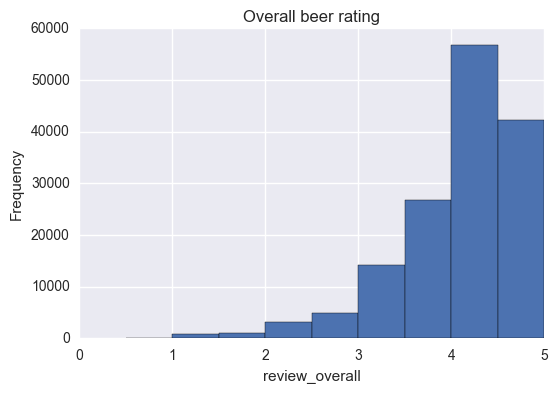

In [10]:
data.review_overall.hist(bins=10)
plt.xlabel("review_overall")
plt.ylabel("Frequency")
plt.title("Overall beer rating");

Using `.unique()` can show the specific rating values:

In [11]:
data.review_overall.unique()

array([ 1.5,  3. ,  4. ,  3.5,  4.5,  5. ,  2. ,  2.5,  1. ,  0. ])

In [12]:
data.review_overall.value_counts().sort_index()

0.0        3
1.0      807
1.5     1054
2.0     3172
2.5     4984
3.0    14216
3.5    26869
4.0    56697
4.5    33237
5.0     8961
Name: review_overall, dtype: int64

Also note that the beer-drinker reviews are not unique, as some people have filed multiple reviews per beer.  We generally take the average rating in such case.

In [13]:
n_reviews = data.groupby(['beer_beerid', 'review_profilename']).review_overall.nunique()
n_reviews.value_counts()

1    147421
2       930
3        13
Name: review_overall, dtype: int64

To show that there are multiple reviews for some users:

<hr>
## Content-based filtering

Content-based filtering maps the data into a feature space, in which we can compare beers and drinkers.  Each beer will get a representation in this space (a high alcohol, IPA-like beer from Founders brewery).  Each drinker gets a taste profile (likes high alcohol beers, likes IPAs but dislikes anything from Founders).

Features we will use:
- brewery id
- beer style 
- alcohol percentage (ABV)

We use the brewery as a feature, but it is not sure this is a useful feature, and it might cause overfitting.

### Creating feature matrix (or item profiles)

#### ABV and Brewery ID

We will categorize the ABV feature into bins.

Currently, there are 177 unique values for `beer_abv`:

In [14]:
data.beer_abv.nunique()

177

To categorize the abv values:

1. round off to whole abv values
2. bin values lower or equal to 4 to 4 and values greater than or equal to 10 to 10
3. leave values between 4 and 10 as is
4. convert abv values into strings (to prepare for patsy)

In [15]:
min_bin, max_bin = 4, 10
abv = data.beer_abv.round()

In [16]:
abv[abv <= min_bin] = min_bin

In [17]:
abv[abv >= max_bin] = max_bin

In [18]:
abv.unique()

array([  5.,   6.,   8.,   4.,   7.,  nan,   9.,  10.])

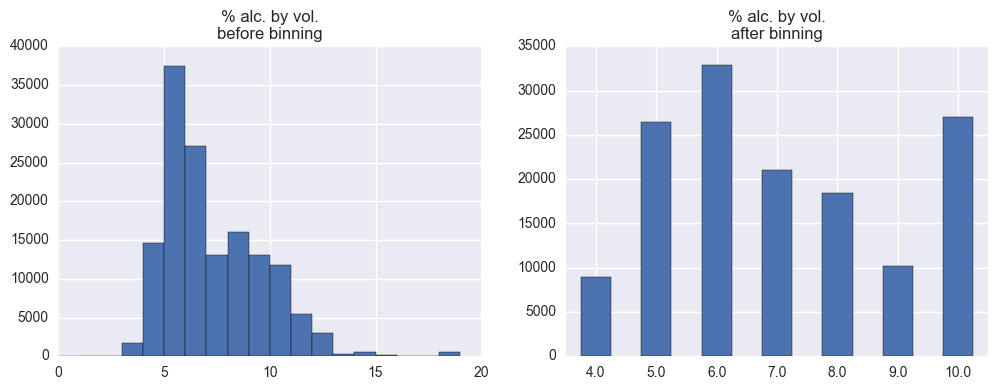

In [19]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
f = data.beer_abv.hist(bins=range(0, 20), ax=axes[0])
axes[0].set_title("% alc. by vol.\nbefore binning")
f = abv.value_counts().sort_index().plot(kind='bar', rot=0, ax=axes[1], title="% alc. by vol.\nafter binning")

We convert numerical values to strings, so patsy will treat them as categorical features

In [20]:
data['beer_abv_cat'] = abv.dropna().astype(int).astype(str)

*** Including `brewery_id` as a feature: ***

In [21]:
data['brewery_id_str'] = data.brewery_id.astype(str)

In [22]:
X_abv_brew = dmatrix('beer_abv_cat + brewery_id_str', data=data.fillna(0), return_type='dataframe')

To learn more about patsy.dmatrix, see http://patsy.readthedocs.io/en/latest/

In [24]:
X_abv_brew.shape

(150000, 596)

In [25]:
X_abv_brew.head()

,Intercept,beer_abv_cat[T.10],beer_abv_cat[T.4],beer_abv_cat[T.5],beer_abv_cat[T.6],beer_abv_cat[T.7],beer_abv_cat[T.8],beer_abv_cat[T.9],brewery_id_str[T.10101],brewery_id_str[T.10103],...,brewery_id_str[T.9483],brewery_id_str[T.954],brewery_id_str[T.9608],brewery_id_str[T.9645],brewery_id_str[T.971],brewery_id_str[T.9729],brewery_id_str[T.9734],brewery_id_str[T.9816],brewery_id_str[T.9827],brewery_id_str[T.9932]
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Beer style

Let's use each word in the beer style as a feature as well (e.g., "IPA")

In [26]:
max_features = 5000
cv = CountVectorizer(max_features=max_features)
X_style = cv.fit_transform(data.beer_style)

In [28]:
X_style

<150000x120 sparse matrix of type '<type 'numpy.int64'>'
	with 416728 stored elements in Compressed Sparse Row format>

In [29]:
X_style.shape

(150000, 120)

##### Putting all the features together to create the feature matrix

In [27]:
X = np.hstack([X_abv_brew, X_style.toarray()])
y = data.review_overall
n_samples, n_features = X.shape

Done! Now we have a feature matrix $X$ with ratings in $y$, containing both beers and drinkers.

### Dot-product method

Since the features only describe beer characteristics, each beer entry in $X$ has the same values for the same beer. So we can just take a beer's first occurance for its representation.

In [30]:
uniques, idx = np.unique(data.beer_beerid, return_index=True)
beer_features = pd.DataFrame(X[idx, :], index=data.beer_beerid[idx])
print beer_features.shape
beer_features.head(2)

(6420, 716)


,0,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
beer_beerid,,,,,,,,,,,,,,,,,,,,,
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### User profiles

A drinker, however, has different ratings for each beer. Per entry, we will broadcast his or her ratings over the features.

For example,

            low-abv  high-abv  IPA  Stout  Pilsner rating
    beer 1     1        0       0     0       1     2.0
    beer 2     0        1       1     0       0     4.5
    
...will become...

            low-abv  high-abv  IPA  Stout  Pilsner
    beer 1    2.0       0       0     0      2.0
    beer 2     0       4.5     4.5    0       0 
    
... and then we average all ratings per user to get a user profile. We also subtract 3 from each rating, so bad ratings are negative and good ratings positives. This is to compensate for all missing entries, which automoatically get a zero-rating (and are now rated as average, instead of terribly bad).

In [31]:
reviewer_features = pd.DataFrame(X * (data.review_overall.values - 3).reshape(n_samples, 1))

In [33]:
reviewer_features['review_profilename'] = data.review_profilename

In [34]:
reviewer_features.head()

,0,1,2,3,4,5,6,7,8,9,...,707,708,709,710,711,712,713,714,715,review_profilename
0,-1.5,-0.0,-0.0,-1.5,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,stcules
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,stcules
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,stcules
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,stcules
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,johnmichaelsen


In [35]:
reviewer_features = reviewer_features.groupby('review_profilename')[range(n_features)].mean()

In [36]:
reviewer_features = reviewer_features.divide(reviewer_features.sum(axis=1), axis=0)

In [37]:
reviewer_features.head()

,0,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.168582,0.080460,0.0,0.000000,0.038314,0.022989,0.030651,-0.003831,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.011494,0.0,0.003831,0.0
05Harley,0.173554,0.074380,0.0,0.000000,0.024793,0.041322,0.016529,0.016529,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.008264,0.000000,0.0,0.000000,0.0
0tt0,0.196429,0.000000,0.0,0.035714,0.000000,0.107143,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
100floods,0.176056,0.084507,0.0,0.000000,0.021127,0.056338,0.014085,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
100proof,0.200000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


** Start of actual determination of recomendations for a user: **

We now simply take the dot product of the beer vector and the drinker vector.  This means that we will add a user's ratings for each of the beer's features.  

Let's pick an arbitrary user.

In [38]:
user = 'WesWes'

Compute user's vector and all beer vectors, and take dot product.

In [39]:
v = reviewer_features.loc[user].values

In [40]:
M = beer_features.values

In [41]:
pred = M.dot(v)

In [42]:
pred = pd.Series(pred, index=beer_features.index, name="predictions").sort_values(ascending=False, inplace=False)

In [43]:
pred_name = pd.Series(pred.values, beer_names[pred.index], name=pred.name)

In [44]:
print "Top recommendations for {}:".format(user)
print pred_name.head()

Top recommendations for WesWes:
beer_name
Sierra Nevada Pale Ale                  0.409924
Extra Special Pale Ale (ESP)            0.409924
Founders Brassworks Ale                 0.404890
Allocation Ale - Beer Camp #52          0.401654
Sierra Nevada Draught Style Pale Ale    0.401654
Name: predictions, dtype: float64


In [45]:
print "Bottom  recommendations (don't drink these, {}!)".format(user)
print pred_name.tail()

Bottom  recommendations (don't drink these, WesWes!)
beer_name
Europa Schwartz Pils         0.174038
Bald Eagle Kristallweizen    0.174038
Roggenbier                   0.174038
Zwickelbier                  0.174038
Replic Ale (2010)            0.174038
Name: predictions, dtype: float64


How do they compare with his actual reviews?  (Note that we take the mean since multiple reviews per drinker-beer pair occur.)

In [46]:
user_reviews = data[data.review_profilename == user].groupby('beer_beerid').review_overall.mean().sort_values(ascending=False, inplace=False)

In [47]:
user_reviews_name = pd.Series(user_reviews.values, index=beer_names[user_reviews.index])

In [48]:
print "Top reviewed by {}:".format(user)
print user_reviews_name.head()

Top reviewed by WesWes:
beer_name
Black Tuesday                              5.0
Founders KBS (Kentucky Breakfast Stout)    5.0
Northern Hemisphere Harvest Wet Hop Ale    5.0
Stoudt's Double IPA (India Pale Ale)       5.0
Founders CBS Imperial Stout                5.0
dtype: float64


In [49]:
print "Bottom reviewed by {}:".format(user)
print user_reviews_name.tail()

Bottom reviewed by WesWes:
beer_name
Weizen Berry                               3.0
Heineken Premium Light Lager               3.0
Pikop Andropov's Rushin' Imperial Stout    3.0
ESB Amber Ale                              3.0
Organic Münster Alt                        3.0
dtype: float64


Let's compare them all.

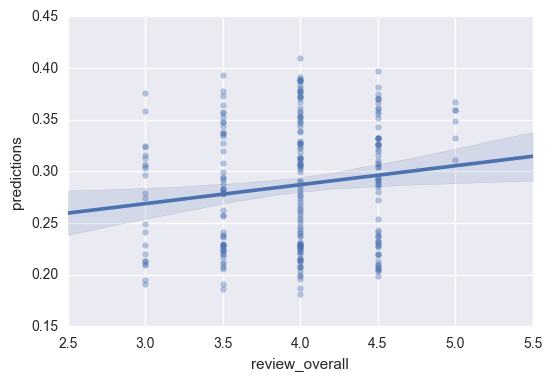

In [50]:
f = sb.regplot(user_reviews, pred[list(user_reviews.index)], scatter_kws=dict(alpha=.4))

Not bad. Note that we completely ignored overfitting and cross validation for readability's sake.

#### Linear Regression

Given this feature matrix and user reviews, we could also use a simple linear regression to predict a review for a user.  We will limit our dataset to the reviews of one user only, and then feed those into the model.

In [51]:
print "Filtering reviews by {}:".format(user)
idx = (data.review_profilename == user).values  # filter reviews of user
X_user, y_user = X[idx, :], y[idx]
print X_user.shape, y_user.shape

Filtering reviews by WesWes:
(253, 716) (253,)


In [52]:
model = Ridge()
model.fit(X_user, y_user)
print cross_val_score(model, X_user, y_user, scoring='neg_mean_absolute_error')
print cross_val_score(model, X_user, y_user, scoring='r2')

[-0.42260271 -0.39218923 -0.38307428]
[-0.22913789 -0.14327301  0.04404437]


Pretty bad cross-validation scores, but mind you we have only a handful reviews.

In [53]:
uniques, idx = np.unique(data.beer_beerid, return_index=True)  # find beer labels
pred = pd.Series(model.predict(X[idx, :]), index=data.beer_beerid[idx], name="predictions") \
    .sort_values(ascending=False, inplace=False)
pred_name = pd.Series(pred.values, beer_names[pred.index], name="predictions")
print "Top recommendations for {}.".format(user)
print pred_name[:5]

Top recommendations for WesWes.
beer_name
Sierra Nevada Imperial Stout                               4.796611
Able I.P.A.                                                4.790692
The Colonel's Porter                                       4.780963
The Colonel's Porter (Cask Primed With English Treacle)    4.780963
Samson                                                     4.752497
Name: predictions, dtype: float64


Let's see how those relate to his actual reviews.

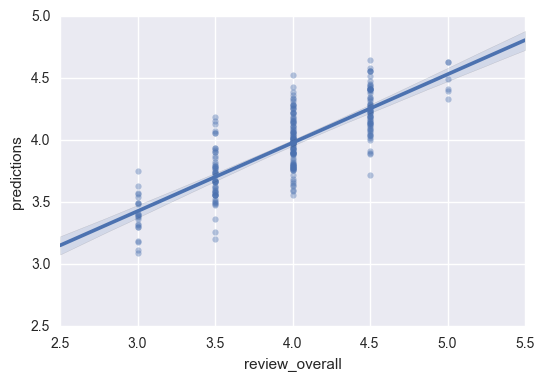

In [54]:
f = sb.regplot(user_reviews, pred[list(user_reviews.index)], scatter_kws=dict(alpha=.4))

Pretty spectacular. 

Just for the fun of it, how will this user rate a random beer?

In [66]:
beer = np.random.choice(beer_names.index)
beer_idx = (data.beer_beerid == beer).values
X_beer = X[beer_idx, :][0]  # just take the first entry
print "{} will give beer {} a rating of {:.1f}.".format(user, beer_names[beer], model.predict(X_beer.reshape(1,-1))[0])

WesWes will give beer Gunpowder Plot a rating of 4.1.


<hr>

## Collaborative filtering

With content-based filtering, we mapped our items and users into some feature space, in which we did our calculations. With _collaborative filtering_, however, we will not use any external features, but compare items with users directly.  This has as a great advantage we can give recommendations based on seemingly unrelated topics.  For example, we can keep track of someone's beer and movie ratings, and predict beer tastes based on someone's movie preferences (assuming there's a correlation between the two).

We have two kinds of collaborative filtering, _item-based_ and _model-based_.

### Item-based collaborative filtering

For _item-based collaborative filtering_, recommendations for are user are based on similar items that the user has already rated highly. It's the approach known as "because you liked this, we think you'd also like this..".  This method is also called _memory-based collaborative filtering_.  These neighborhood methods are popular and easy to understand, but they don’t scale well. 

In [68]:
# Create beer x drinker preference matrix
M = data.groupby(['beer_beerid', 'review_profilename']).review_overall.mean().unstack()
M = np.maximum(-1, (M - 3).fillna(0) / 2.)  # scale to -1..+1  (treat "0" scores as "1" scores)
M.head(2)

review_profilename,0110x011,05Harley,0tt0,100floods,100proof,1099.0,110toyourleft,1121987.0,11osixBrew,11thFloorBrewing,...,ztruempy,zuccard,zuffenhausen,zuggy9,zuker,zumicroom,zwoehr,zymurgy4all,zymurgywhiz,zythus
beer_beerid,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
n_ratings = data.groupby(['beer_beerid', 'review_profilename']).size()
n_ratings[n_ratings  > 1] = 1  # just keep 1 or 0 for user-beer rating
n_ratings = n_ratings.unstack().fillna(0)  # create matrix, fill empty cells with 0
n_ratings = n_ratings.dot(n_ratings.T)  # how many ratings do two beers have in common?

In [70]:
# if we have `ignore_up_to_n` or less common ratings between two beers, just ignore it
ignore_up_to_n = 3
n_ratings = np.maximum(ignore_up_to_n, n_ratings).replace(ignore_up_to_n, np.nan)

In [71]:
sim = M.dot(M.T)  # total score in common between two beers
sim = sim / n_ratings  # scale so we get an average score (not a sum)
# note that if we have no common ratings, we get a NaN now

In [72]:
n_ratings = data.groupby(['beer_beerid']).size()
beers = n_ratings[n_ratings > 10].index

In [74]:
n_beers = 5
top = 5
print 
for beer in np.random.choice(beers, n_beers):
    print "--", beer_names[beer], "--"
    sim_beers = sim[beer].sort_values(ascending=False, inplace=False).dropna()
    if len(sim_beers) == 0:
        print "Not enough comparisons"
    else:
        print "MOST  similar:", ", ".join(beer_names[list(sim_beers.head(top).index)])
        print "LEAST similar:", ", ".join(beer_names[list(sim_beers.tail(top).index)])
    print


-- Super Bock Stout --
MOST  similar: Sierra Nevada Southern Hemisphere Harvest Fresh Hop Ale, Sierra Nevada Torpedo Extra IPA, Sierra Nevada Celebration Ale, Super Bock Stout, Sierra Nevada Pale Ale
LEAST similar: Pilsner Urquell, Asahi Super Dry, Duchesse De Bourgogne, Super Bock, Guava Grove Saison

-- Watershed IPA --
MOST  similar: Exit 11, Palone, Stillwater Chardonnay Barrel-Aged Stateside Saison, Weltenburger Pils, Hirsch Bavarian-Weissbier Hefeweisse
LEAST similar: Frosted Frog Christmas Ale, Castle Lager, Amstel Light, Genesee Beer, Newport Storm Hurricane Amber Ale

-- Heineken Tarwebok --
MOST  similar: Founders KBS (Kentucky Breakfast Stout), Founders Double Trouble, St-Ambroise Oatmeal Stout, Heineken Tarwebok, 30th Anniversary - Fritz And Ken's Ale
LEAST similar: Boddingtons Pub Ale, Sierra Nevada Tumbler Autumn Brown Ale, Heineken Dark Lager, Heineken Lager Beer, Asahi Super Dry

-- Rudyard's Rare Barley Wine --
MOST  similar: The Mother Of All Beers (Quadrupel), Sweet

Hmm, not super convincing yet.

#### Recommendations for a user

Let's look at our old friend again.

In [76]:
print "Top reviews by {}.".format(user)
print user_reviews_name.head()

Top reviews by WesWes.
beer_name
Black Tuesday                              5.0
Founders KBS (Kentucky Breakfast Stout)    5.0
Northern Hemisphere Harvest Wet Hop Ale    5.0
Stoudt's Double IPA (India Pale Ale)       5.0
Founders CBS Imperial Stout                5.0
dtype: float64


In [78]:
top = 5
favorite_beers = list(user_reviews[user_reviews > 4].index)
pred = sim[favorite_beers].mean(axis=1).dropna().sort_values(ascending=False, inplace=False)
pred_name = pd.Series(pred.values, beer_names[pred.index], name=pred.name)
print "Top recommendations for {}".format(user)
print pred_name.head()
print "\nBottom  recommendations (don't drink these, {}!)".format(user)
print pred_name.tail()

Top recommendations for WesWes
beer_name
Funky Barrel                       0.637500
Hop Project #21                    0.566406
The Worthy Adversary               0.562500
Wobbly Bob APA                     0.557500
Founders Hop Spit Punk Rock IPA    0.544922
dtype: float64

Bottom  recommendations (don't drink these, WesWes!)
beer_name
Golden Zhujiang        -0.328125
Trafalgar Maple Bock   -0.331760
Hite Prime             -0.350781
Thunder                -0.351562
Coopers Light Beer     -0.408750
dtype: float64


These seem to correspond pretty well with his actual scores.

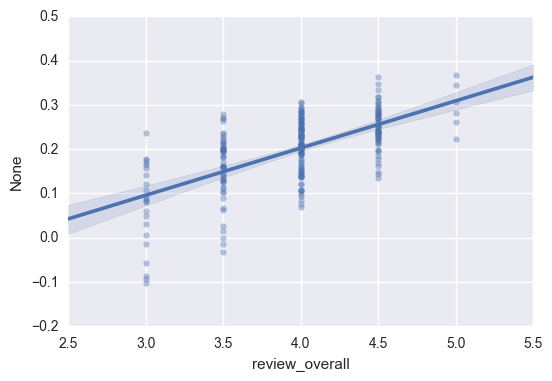

In [80]:
f = sb.regplot(user_reviews, pred[list(user_reviews.index)], scatter_kws=dict(alpha=.4))

### Model-based collaborative filtering

In _model-based collaborative filtering_ we will estimate parameters for both items and users simultaneously.  This apporach is considered to be the state of the art and gets generally the highest prediction accuracy.

The most popular model-based CF techniques use matrix decomposition techniques to find deeper structure in the ratings data.  For example, we could decompose the ratings matrix via SVD to reduce the dimensionality and extract latent variables. 

Once we identify the latent variables in the ratings matrix, we can express both users and items in terms of these latent variables.  As before, values in the item vectors represent the degree to which an item exhibits a given feature, and values in the user vectors represent user preferences for a given feature.  Ratings are constructed by taking dot products of user & item vectors in the latent feature space.

#### SVD-based models

In [81]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [84]:
n_components = 75  # 200   # number of beer classes
svd = TruncatedSVD(n_components)
X_red = svd.fit_transform(M.T)
explained_variance = svd.explained_variance_ratio_.sum()

In [90]:
print "Explained variance of the SVD step: {:.0f}".format(explained_variance * 100)
print "Dimensions feature matrix (old):", M.T.shape
print "Dimensions feature matrix (new):", X_red.shape

Explained variance of the SVD step: 57
Dimensions feature matrix (old): (13964, 6420)
Dimensions feature matrix (new): (13964, 75)


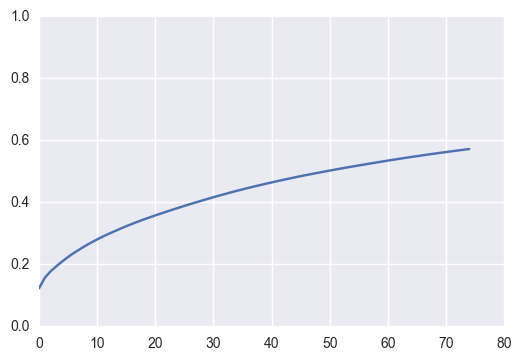

In [91]:
plt.plot(svd.explained_variance_ratio_.cumsum())
f = plt.ylim(0,1)

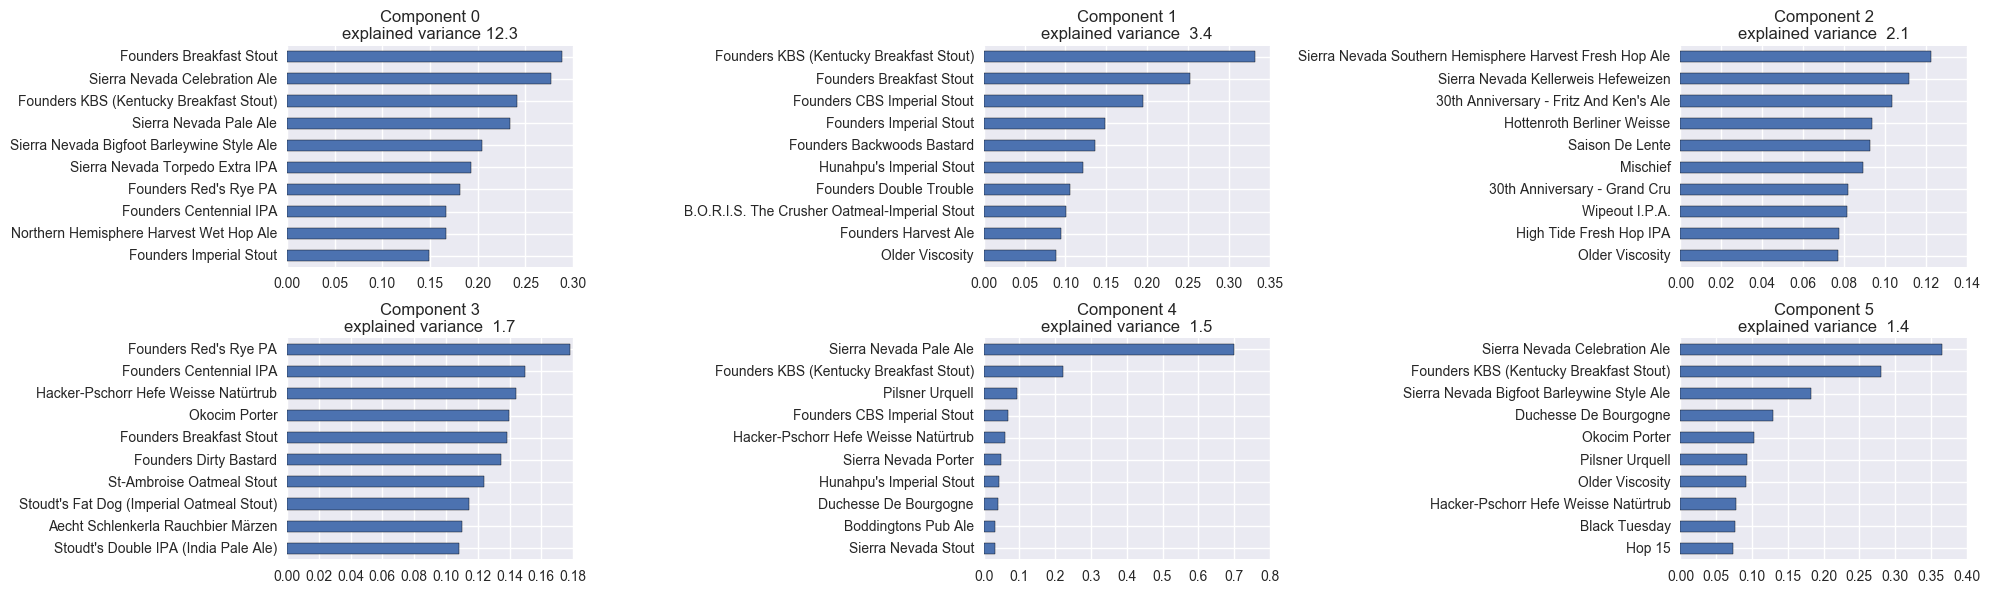

In [92]:
beers = M.index
top_beers = 10
n_rows, n_cols = 2, 3
top_components = n_rows * n_cols
f, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
for no, component in enumerate(svd.components_[:top_components]):
    ax = axes[no / n_cols][no % n_cols]
    s = pd.Series(svd.components_[no], index=beer_names[beers].values).sort_values(inplace=False)[-top_beers:]
    s.plot(kind='barh', ax=ax, title="Component %d\nexplained variance %4.1f" % 
           (no, 100 * svd.explained_variance_ratio_[no]))
f = plt.tight_layout()

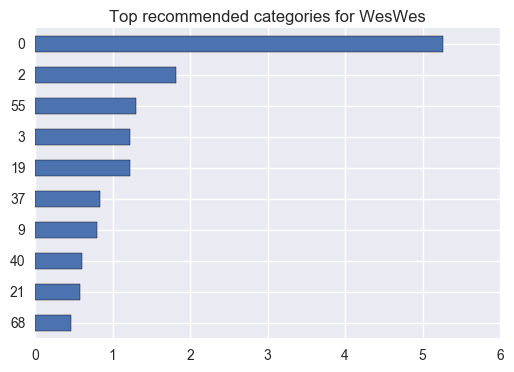

In [93]:
userid = list(M.columns).index(user)
recs = pd.Series(X_red[userid])
f = recs.sort_values(inplace=False)[-10:].plot(kind='barh', title='Top recommended categories for %s' % user)

In [94]:
beers_from_top_category = pd.Series(svd.components_[recs.argmax()], index=beer_names[beers].values)
print "Beers from top recommended category for %s:" % user,
print ', '.join(beers_from_top_category.sort_values(inplace=False)[-top_beers:].index)

Beers from top recommended category for WesWes: Founders Imperial Stout, Northern Hemisphere Harvest Wet Hop Ale, Founders Centennial IPA, Founders Red's Rye PA, Sierra Nevada Torpedo Extra IPA, Sierra Nevada Bigfoot Barleywine Style Ale, Sierra Nevada Pale Ale, Founders KBS (Kentucky Breakfast Stout), Sierra Nevada Celebration Ale, Founders Breakfast Stout


Take dot product again to get individual beers, recommended for user.  Note that beers are represented in different components, so this is really a different set than the one before.

In [95]:
beer_recs = X_red[userid].dot(svd.components_)
beer_recs = pd.Series(beer_recs, index=beer_names[beers].values)
print "Beers recommended for %s:" % user,
print ', '.join(beer_recs.sort_values(inplace=False)[-top_beers:].index)

Beers recommended for WesWes: Sierra Nevada Porter, Founders Blushing Monk, Estate Homegrown Wet Hop Ale, Founders Backwoods Bastard, Northern Hemisphere Harvest Wet Hop Ale, Founders KBS (Kentucky Breakfast Stout), Hoptimum Double IPA - Beer Camp #19, Stoudt's Double IPA (India Pale Ale), Founders CBS Imperial Stout, Black Tuesday


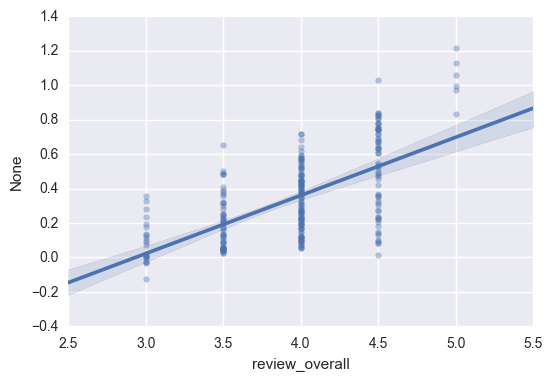

In [96]:
pred = pd.Series(recs.dot(svd.components_), index=beers)
f = sb.regplot(user_reviews, pred[list(user_reviews.index)], scatter_kws=dict(alpha=.4))